### Importing Necessary Libraries

In [34]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.manifold import TSNE

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [ ]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [ ]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})
label_names

## Data Preparation

Since, there is a lot of image data instead of using the whole data at once in a tensor form, we would be using a data generator to prevent memory issues.

In [8]:
imgs = [tf.cast(img_to_array(load_img('./Data/validation/validation/'+name)), dtype=tf.uint8) for name in os.listdir('./Data/validation/validation')[:4]]
heights = [img.shape[0] for img in imgs]
widths = [img.shape[1] for img in imgs]
print("")
print("Mean Image Height:", np.mean(heights))
print("Mean Image Width:", np.mean(widths))
print("Min Image Height:", np.min(heights))
print("Min Image Width:", np.min(widths))


Mean Image Height: 1000.0
Mean Image Width: 770.5
Min Image Height: 1000
Min Image Width: 754


Observing the average image heights and widths, it is observed that setting image height to $1000$ and image width to $750$ is reseonable for training the model.

In [9]:
BATCH_SIZE = 40
INPUT_SHAPE = (800, 600) # Full Image
INPUT_HDR_SHAPE = INPUT_FTR_SHAPE = (250, 600)
INPUT_BDL_SHAPE = INPUT_BDR_SHAPE = (300, 300)

Since, the Keras' own data generator does not support TIFF images, we resort to writing our own custom data generator. It can also be leveraged to put custom image pre-processing or multi-input or output in the data processing pipeline.

In [10]:
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size, input_size=(800, 600), shuffle=True):
        self.df = df.copy() # DataFrame consisting image paths of inputs and the labels for the outputs
        self.X_col = X_col # Input column, specifying image path, in the DataFrame
        self.y_col = y_col # Output column, specifying corresponding label, in the DataFrame
        self.batch_size = batch_size # Batch Size
        self.input_size = input_size # Input Image size
        self.shuffle = shuffle # Shuffle Data after each epoch
        self.n = len(self.df) # length of the entire data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        img_arr = img_to_array(load_img(path))
        # some other pre-processing / data-augmentation goes here
        img_arr = tf.image.resize(img_arr, self.input_size)
        img_hdr, img_bdl, img_bdr, img_ftr = img_arr[:250], img_arr[250:-250, :300], img_arr[250:-250, -300:], img_arr[-250:]
        return [img_hdr/255.0, img_bdl/255.0, img_bdr/255.0, img_ftr/255.0, img_arr/255.0]
    
    def __get_data(self, batches):
        batch_paths = batches[self.X_col]
        batch_labels = batches[self.y_col]
        X_batch_4 = [self.__get_input(path) for path in batch_paths]
        X_batch = tf.cast([img[0] for img in X_batch_4], dtype=tf.float32), tf.cast([img[1] for img in X_batch_4], dtype=tf.float32), tf.cast([img[2] for img in X_batch_4], dtype=tf.float32), tf.cast([img[3] for img in X_batch_4], dtype=tf.float32), tf.cast([img[4] for img in X_batch_4], dtype=tf.float32)
        y_batch = tf.cast(batch_labels, dtype=tf.float32)
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [11]:
train_generator = ImageDataGenerator(
    df=labels,
    X_col='images',
    y_col='label',
    batch_size=BATCH_SIZE,
    input_size=INPUT_SHAPE,
    shuffle=False
)

Below shows one batch from the ImageDataGenerator.

In [12]:
batch = next(iter(train_generator))
print('*** Batch Overview ***')
print('Number of Inputs:', len(batch[0]))
print('Input Image Header Tensor Shape:', batch[0][0].shape)
print('Input Image Body(L) Tensor Shape:', batch[0][1].shape)
print('Input Image Body(R) Tensor Shape:', batch[0][2].shape)
print('Input Image Footer Tensor Shape:', batch[0][3].shape)
print('Input Image Full Tensor Shape:', batch[0][4].shape)
print('Output Label Tensor Shape:', batch[1].shape)

*** Batch Overview ***
Number of Inputs: 5
Input Image Header Tensor Shape: (40, 250, 600, 3)
Input Image Body(L) Tensor Shape: (40, 300, 300, 3)
Input Image Body(R) Tensor Shape: (40, 300, 300, 3)
Input Image Footer Tensor Shape: (40, 250, 600, 3)
Input Image Full Tensor Shape: (40, 800, 600, 3)
Output Label Tensor Shape: (40,)


Each row below shows the $4$ parts of the same image and the full image, where the first being the header, second being the body(left), third is body(right) and last one is footer and the full image.

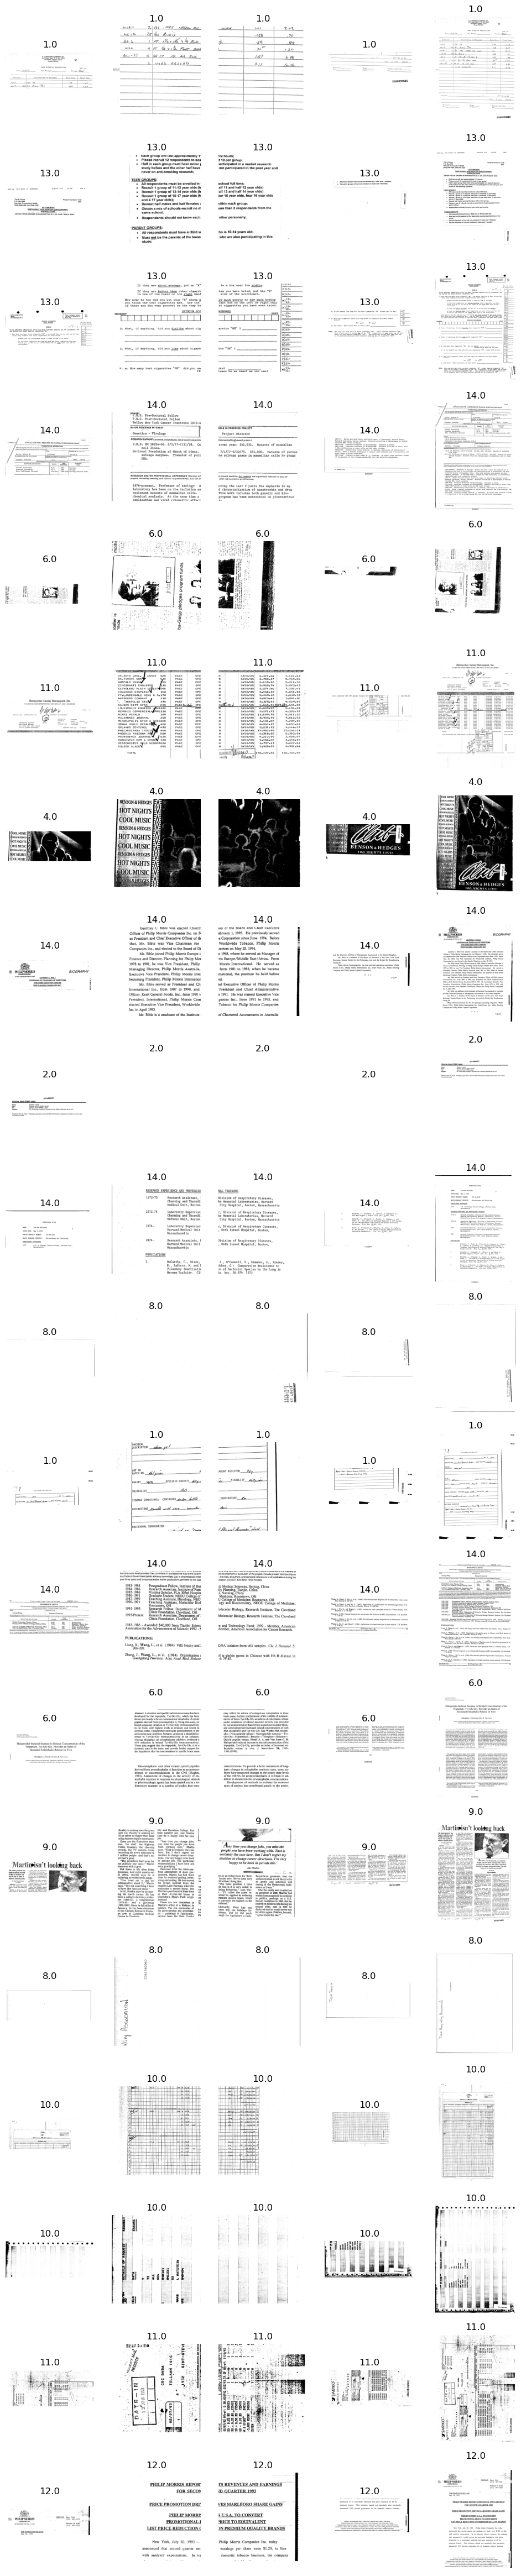

In [13]:
fig, ax = plt.subplots(BATCH_SIZE//2, 5, figsize=(12, 60))
imgs = batch[0]
labs = list(batch[1].numpy())
for j in range(BATCH_SIZE//2):
    for k in range(5):
        ax[j, k].imshow((imgs[k][j]*255).numpy().astype(np.uint8))
        ax[j, k].axis('off')
        ax[j, k].set_title(labs[j])

## Model Building

Now, a basic CNN-based model will be put to place. It will utilize the visual features only to classify the documents. Later we will be building much more better models considering other structures and multi-modality of the images and distinctive features.

- EfficientNetV2L

The EfficientNetV2L is a large model and since, we are not pre-training the entire model, we will just fine-tune it with two extra layers. So, to fasten training we precompute the output of the EfficientNetV2L model and use this for training the added Dense Layers for Fine-Tuning.

In [14]:
model_effnet = EfficientNetV2L(include_top=False, weights='imagenet')
model_effnet.trainable = False

In [15]:
inputs = [Input(shape=(*INPUT_HDR_SHAPE, 3)), Input(shape=(*INPUT_BDL_SHAPE, 3)), Input(shape=(*INPUT_BDR_SHAPE, 3)), Input(shape=(*INPUT_FTR_SHAPE, 3)), Input(shape=(*INPUT_SHAPE, 3))]
outputs = [model_effnet(inp) for inp in inputs]
outputs = [GlobalAvgPool2D()(out) for out in outputs]
model = tf.keras.Model(inputs, outputs, name='EfficientNet-4Piece')

In [16]:
model.summary()

Model: "EfficientNet-4Piece"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                              

In [17]:
# precompute_EffNet_output = 0
# for idx in range(len(labels)//1600):
#     train_generator_precompute = ImageDataGenerator(
#         df=labels[idx*1600:(idx+1)*1600],
#         X_col='images',
#         y_col='label',
#         batch_size=BATCH_SIZE,
#         input_size=INPUT_SHAPE,
#         shuffle=False
#     )
#     precompute_EffNet_output = model.predict(train_generator_precompute)
#     np.save(f'./Data/EffNet-4P-train-precompute/train_data_precomp-{idx}.npy', precompute_EffNet_output)

In [18]:
# fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/EffNet-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
# np.save(f'./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
# fine_tune_data.shape

The EfficientNetV2L gives a 3D output per image with $1280$ channels which are collapsed using GlobalAveragePooling2D and we get a 1280 representation vector per 4 parts of the image and full image ($4+1=5$) which will be used to train the later extra layers of our model.

In [19]:
fine_tune_data = np.load('./Data/EffNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 1280)

In [20]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [21]:
def ftmodel():
    inputs = Input(shape=(5, 1280))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(top_dropout_rate, name='top_dropout_final')(x)
    outputs = Dense(16, activation='softmax', name='pred')(x)

    model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-FineTune')
    return model1

In [22]:
model1 = ftmodel()
model1.summary()

Model: "EfficientNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 1280)]         0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 batch_normalization (BatchN  (None, 6400)             25600     
 ormalization)                                                   
                                                                 
 top_dropout_1 (Dropout)     (None, 6400)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              6554624   
                                                                 
 top_dropout_2 (Dropout)     (None, 1024)              0         
                                             

### Model Training

The fine-tuning will be done on the EfficientNet's $1280D$ representation vectors.

In [23]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [24]:
model1.load_weights('./Models/EfficientNet-4P/effnet-4p-model-weights')

In [28]:
model1.layers[-3].output.shape

TensorShape([None, 512])

In [29]:
out = model1.layers[-3].output
model2 = tf.keras.Model(model1.input, out, name='EfficientNet-FT-Feature')

In [30]:
model2.summary()

Model: "EfficientNet-FT-Feature"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 1280)]         0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 batch_normalization (BatchN  (None, 6400)             25600     
 ormalization)                                                   
                                                                 
 top_dropout_1 (Dropout)     (None, 6400)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              6554624   
                                                                 
 top_dropout_2 (Dropout)     (None, 1024)              0         
                                           

In [31]:
train_data = model2.predict(fine_tune_data)

 52/500 [==>...........................] - ETA: 0s

2022-09-11 20:38:11.913249: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-11 20:38:11.945210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 1s 2ms/step


In [32]:
train_data.shape

(16000, 512)

## Learnt Representation Visualization

### T-SNE

Looking at the t-SNE embedding for the learnt vector representation for the documents, we get a good idea of which classes are best clustered together by this learnt representation.

In [35]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd = tsne.fit_transform(train_data)

In [36]:
labs = labels['label'].to_numpy()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'cornflowerblue', 'burlywood', 'magenta', 'indigo']

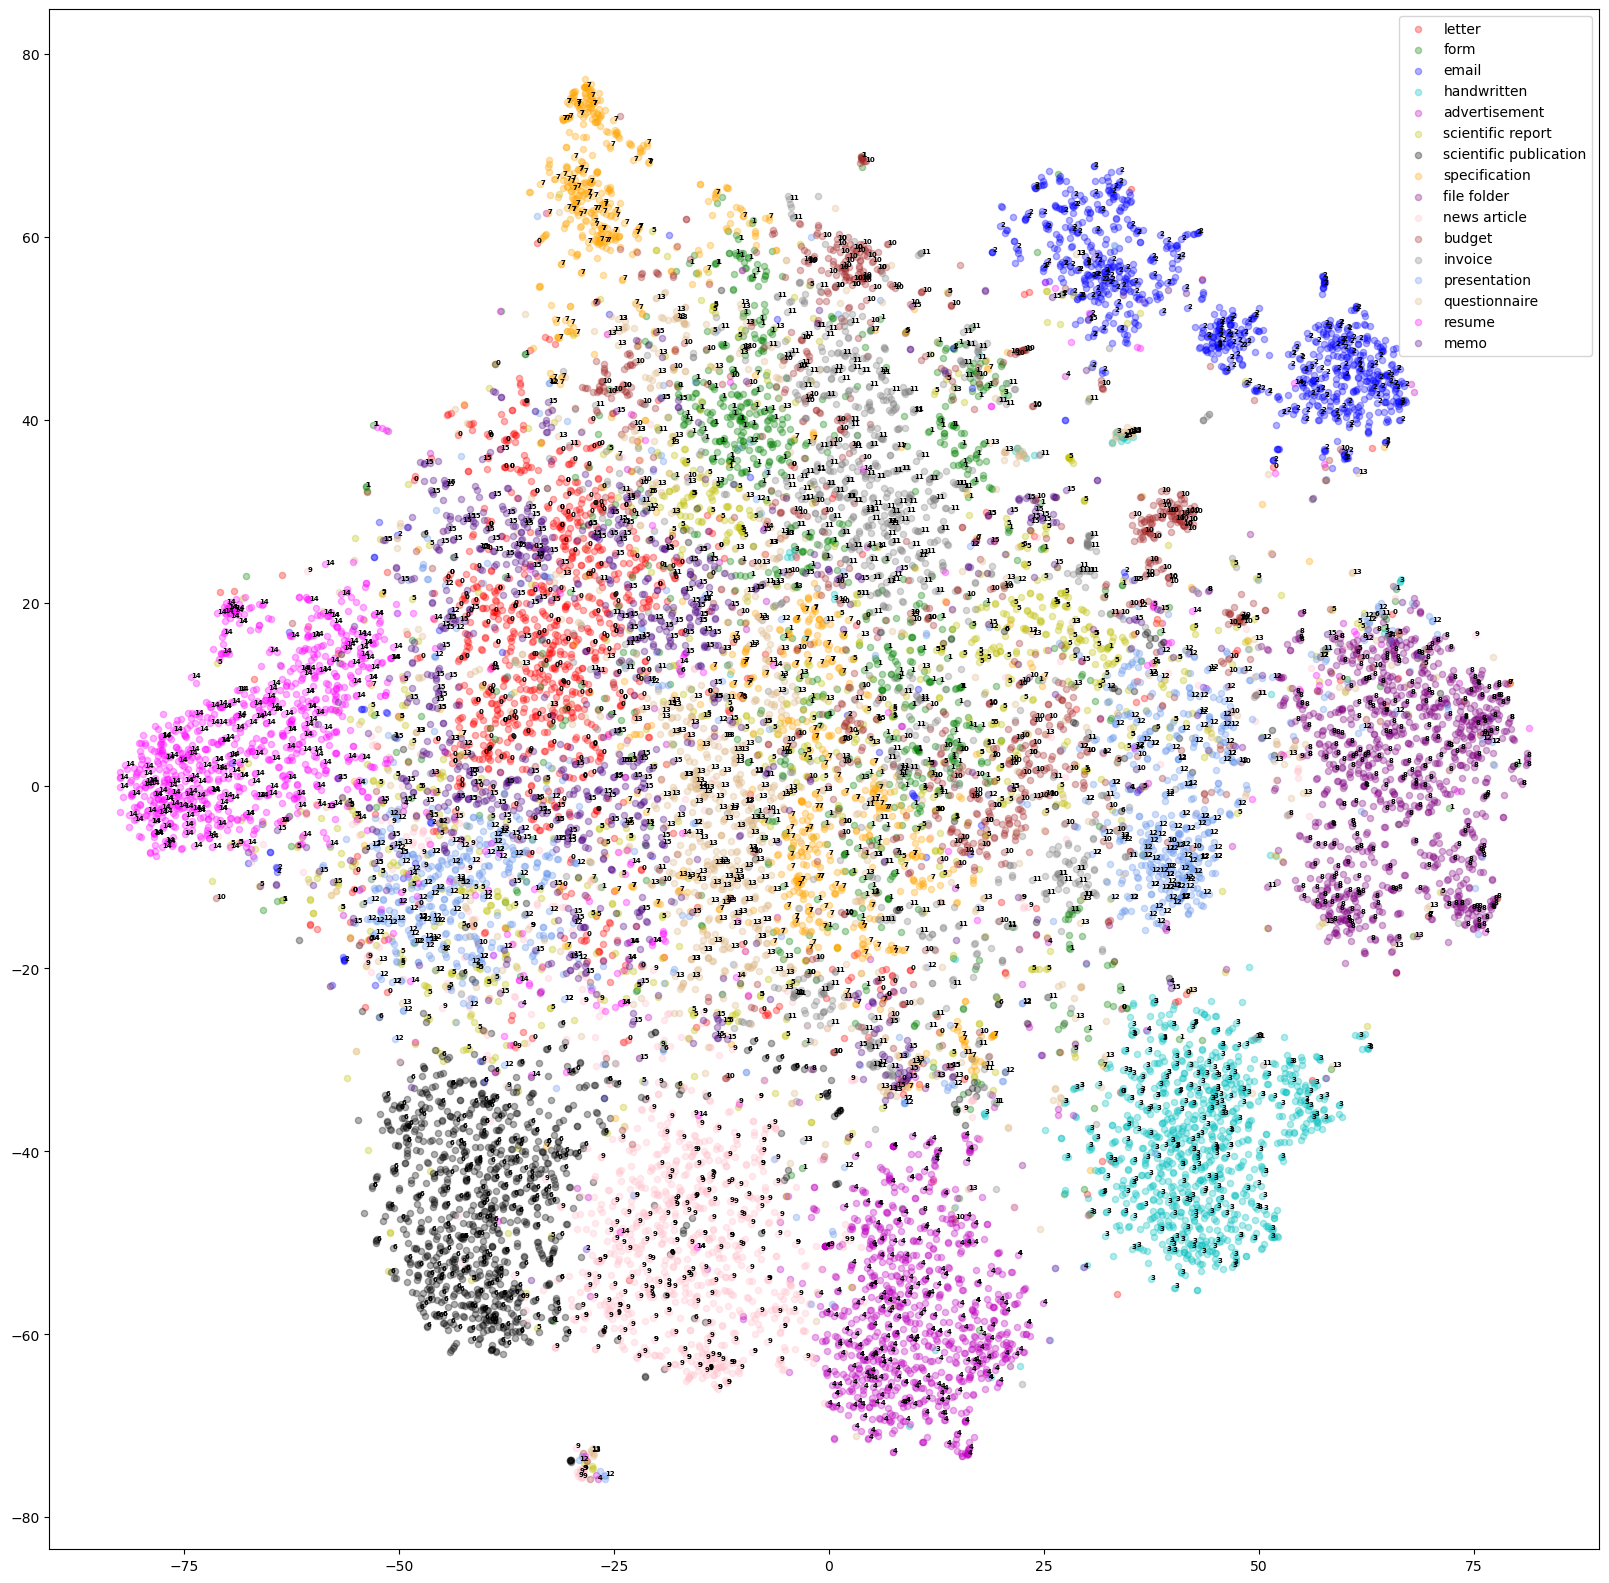

In [37]:
plt.figure(figsize=(20, 20))
for lab, col in zip(class_labels, colors):
    plt.scatter(tsne_embd[labs==lab,0], tsne_embd[labs==lab,1], s=20, c=col, alpha=0.3, label=class_names[lab])
    
    rand = np.random.choice(np.sum(labs==lab), np.sum(labs==lab)//4)
    for pt in rand:
        plt.annotate(lab, (tsne_embd[labs==lab,0][pt], tsne_embd[labs==lab,1][pt]), size=5, weight='bold', color='k')   
plt.legend()
plt.show()